In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Misc
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


### Just playing here, real code begins below

## Load Data

In [2]:
train_path = "X_train.csv"   # <-- adjust paths if needed
y_path     = "y_train.csv"
test_path  = "X_test.csv"

X = pd.read_csv(train_path)
y = pd.read_csv(y_path)
X_test = pd.read_csv(test_path)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("X_test:", X_test.shape)

Shapes:
X: (60000, 170)
y: (60000, 2)
X_test: (16000, 170)


## Convert "na" --> np.nan

In [3]:
X = X.replace("na", np.nan)
X_test = X_test.replace("na", np.nan)

# Convert to floats
X = X.astype(float)
X_test = X_test.astype(float)

## Missing Values

In [4]:
missing_frac = X.isna().mean().sort_values(ascending=False)

## Drop extremely sparse features

In [5]:
# Thresholds for the two pipelines
thr_kbest = 0.30   # only use relatively dense features for KBest
thr_xgb   = 0.95   # keep almost everything for XGBoost-based pipeline

cols_kbest = missing_frac[missing_frac <= thr_kbest].index
cols_xgb   = missing_frac[missing_frac <= thr_xgb].index

print(f"Features for KBest pipeline (<= {thr_kbest*100:.0f}% missing): {len(cols_kbest)}")
print(f"Features for XGB/SFM pipeline (<= {thr_xgb*100:.0f}% missing): {len(cols_xgb)}")


Features for KBest pipeline (<= 30% missing): 160
Features for XGB/SFM pipeline (<= 95% missing): 170


## Single train-validation split, then branch per pipeline

In [6]:
from sklearn.model_selection import train_test_split

y['Prediction'] = y['Prediction'].map({'neg': 0, 'pos': 1})

# Single split so both pipelines see exactly the same instances
X_train_all, X_val_all, y_train, y_val = train_test_split(
    X, y['Prediction'],
    test_size=0.20,
    stratify=y['Prediction'],
    random_state=RANDOM_STATE
)

print("Overall Train:", X_train_all.shape)
print("Overall Val:  ", X_val_all.shape)

# Now create pipeline-specific views
Xk_train = X_train_all[cols_kbest].copy()
Xk_val   = X_val_all[cols_kbest].copy()

Xx_train = X_train_all[cols_xgb].copy()
Xx_val   = X_val_all[cols_xgb].copy()

# Also prepare test matrices for later
Xk_test = X_test[cols_kbest].copy()
Xx_test = X_test[cols_xgb].copy()

print("KBest Train shape:", Xk_train.shape)
print("SFM/XGB Train shape:", Xx_train.shape)


Overall Train: (48000, 170)
Overall Val:   (12000, 170)
KBest Train shape: (48000, 160)
SFM/XGB Train shape: (48000, 170)


## Load like this

In [44]:
import joblib

kbest_model = joblib.load("Materials_Mentioned_in_Report/Models/best_of_nine_model.pkl")
kbest_model_160 = joblib.load("Materials_Mentioned_in_Report/Models/model_kbest_160_pipeline160_2025127.pkl")
sfm_model   = joblib.load("Materials_Mentioned_in_Report/Models/model_sfm_pipeline_2025127.pkl")
logit_model = joblib.load("Materials_Mentioned_in_Report/Models/model_logit_pipeline_2025127.pkl")
logit_model_160 = joblib.load("Materials_Mentioned_in_Report/Models/model_logit_160_pipeline_2025127.pkl")
svm_model = joblib.load("Materials_Mentioned_in_Report/Models/model_svm_pipeline_2025127.pkl")
svm_model_160 = joblib.load("Materials_Mentioned_in_Report/Models/model_svm_160_pipeline_2025127.pkl")
dt_model = joblib.load("Materials_Mentioned_in_Report/Models/model_dectree_pipeline_2025127.pkl")
dt_model_160 = joblib.load("Materials_Mentioned_in_Report/Models/model_dectree_160_pipeline_2025127.pkl")
final_model = joblib.load("Materials_Mentioned_in_Report/Models/final_model_2025127.pkl")

# Visualizations

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, balanced_accuracy_score
from xgboost import XGBClassifier

In [46]:
# Because the final model was chosen as the kbest model with k=120
X_kbest_full = X[cols_kbest].copy()
X_train_final = X_kbest_full

# --- Predictions on hold-out validation ---
pred_sfm = sfm_model.predict(Xx_val)
pred_kb  = kbest_model.predict(Xk_val)
pred_kb_160  = kbest_model_160.predict(Xk_val)
pred_logit  = logit_model.predict(Xk_val)
pred_logit_160  = logit_model_160.predict(Xk_val)
pred_svm  = svm_model.predict(Xk_val)
pred_svm_160  = svm_model_160.predict(Xk_val)
pred_dt  = dt_model.predict(Xk_val)
pred_dt_160  = dt_model_160.predict(Xk_val)
pred_final_model = final_model.predict(X_train_final)

## Model Evaluation Visualizations

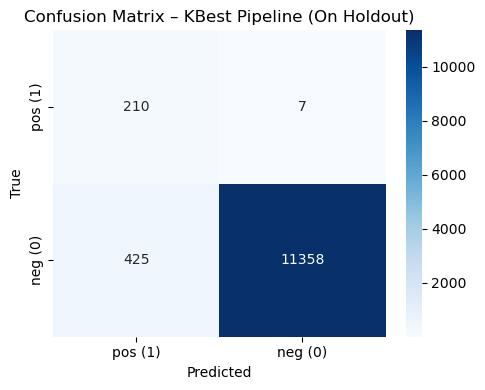

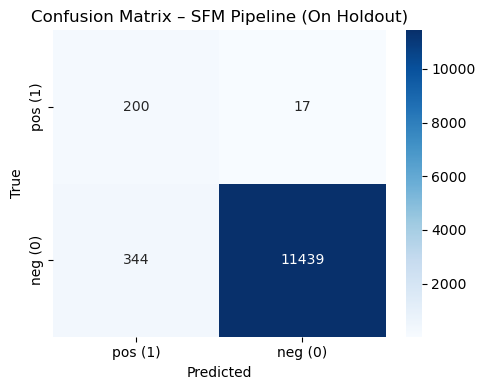

In [47]:
def plot_conf_matrix_tp_first(y_true, y_pred, title):
    # Force label order: positive (1) first, negative (0) second
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["pos (1)", "neg (0)"],   # Predicted
        yticklabels=["pos (1)", "neg (0)"]    # True
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_conf_matrix_tp_first(y_val, pred_kb, "Confusion Matrix – KBest Pipeline (On Holdout)")
plot_conf_matrix_tp_first(y_val, pred_sfm, "Confusion Matrix – SFM Pipeline (On Holdout)")


### ROC Curve
- Not using it due to loss of significance because of too high True Negative Count

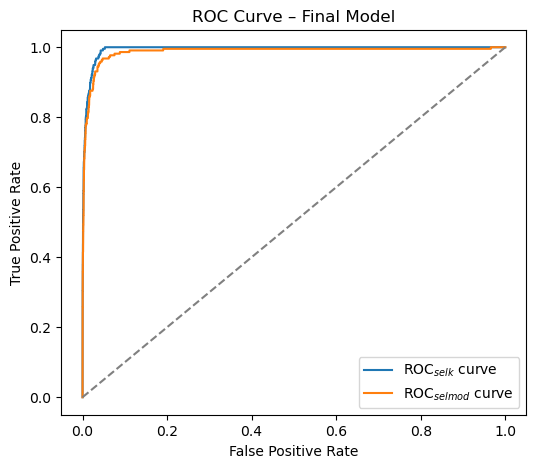

In [48]:
y_score_kbest = kbest_model.predict_proba(Xk_val)[:,1]
fpr_kbest, tpr_kbest, _ = roc_curve(y_val, y_score_kbest)
y_score_sfm = sfm_model.predict_proba(Xx_val)[:,1]
fpr_sfm, tpr_sfm, _ = roc_curve(y_val, y_score_sfm)

plt.figure(figsize=(6,5))
plt.plot(fpr_kbest, tpr_kbest, label=r"ROC$_{selk}$ curve")
plt.plot(fpr_sfm, tpr_sfm, label=r"ROC$_{selmod}$ curve")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final Model")
plt.legend()
plt.show()


### Prec-Recall Curve
- We plot and present this instead of the ROC curve because this is not affected by the high number of negatives (and therefore, high num of True Negatives)

In [49]:
def get_pos_scores(estimator, X):
    """
    Returns a continuous score for the positive class (1).
    Works for sklearn Pipelines and estimators.
    """
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    raise ValueError(f"{type(estimator)} has neither predict_proba nor decision_function.")

def plot_pr_curves(selected_models, y_true, save_path=None):
    """
    selected_models: dict {name: (estimator, X_val_for_that_estimator)}
    y_true: validation labels (0/1), aligned with each X_val
    """
    fig_prec_rec = plt.figure(figsize=(8,6))

    for name, (est, Xv) in selected_models.items():
        scores = get_pos_scores(est, Xv)
        prec, rec, _ = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

    # baseline = prevalence of positive class
    #base = np.mean(y_true)
    #plt.hlines(base, 0, 1, linestyles="dashed", label=f"Baseline (pos rate={base:.3f})")

    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.title("Precision–Recall Curves (Validation)", fontsize=20)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=14)
    plt.tight_layout()
    if save_path is not None:
        fig_prec_rec.savefig(save_path, dpi=600)
    plt.show()


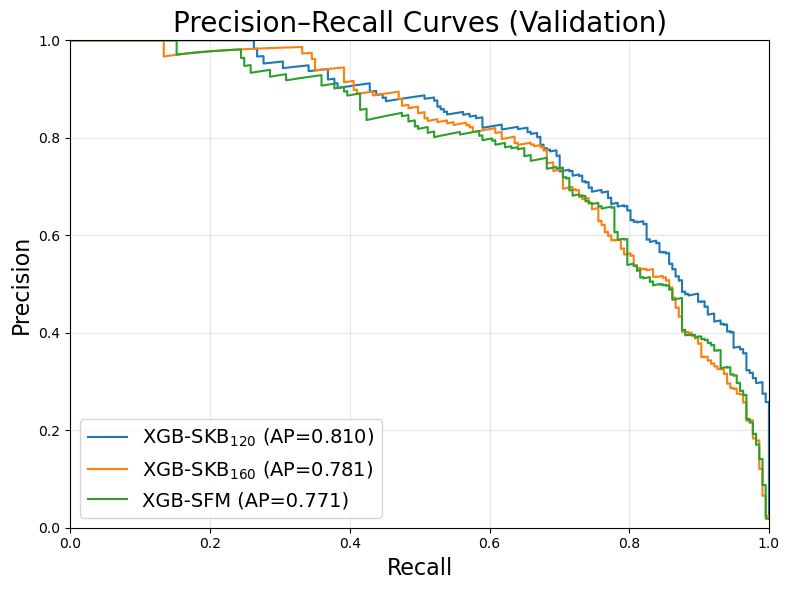

In [50]:
selected = {
    r"XGB-SKB$_{120}$": (kbest_model, Xk_val),
    r"XGB-SKB$_{160}$": (kbest_model_160, Xk_val),
    r"XGB-SFM":         (sfm_model, Xx_val),
}

plot_pr_curves(selected, y_val, save_path="pics/XGB_pr_curves.png")


Note that XGB-SKB_120 is best here for the task bc it gets max prec with highest rec

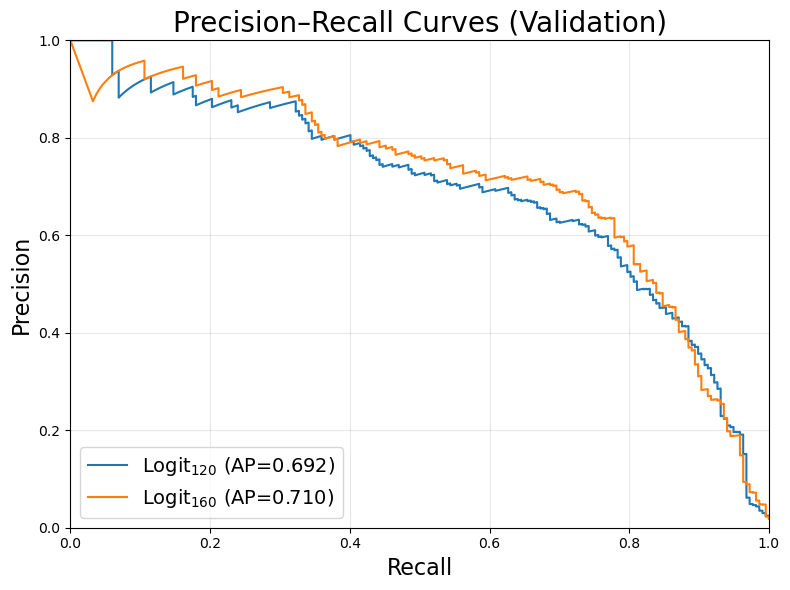

In [51]:
selected2 = {
    r"Logit$_{120}$":       (logit_model, Xk_val),
    r"Logit$_{160}$":       (logit_model_160, Xk_val),
    #r"Dec-Tree$_{120}$":       (opt_dt.best_estimator_, Xk_val),
    #r"Dec-Tree$_{160}$":       (opt_dt_160.best_estimator_, Xk_val),
}

plot_pr_curves(selected2, y_val, save_path="pics/Simples_pr_curves.png")

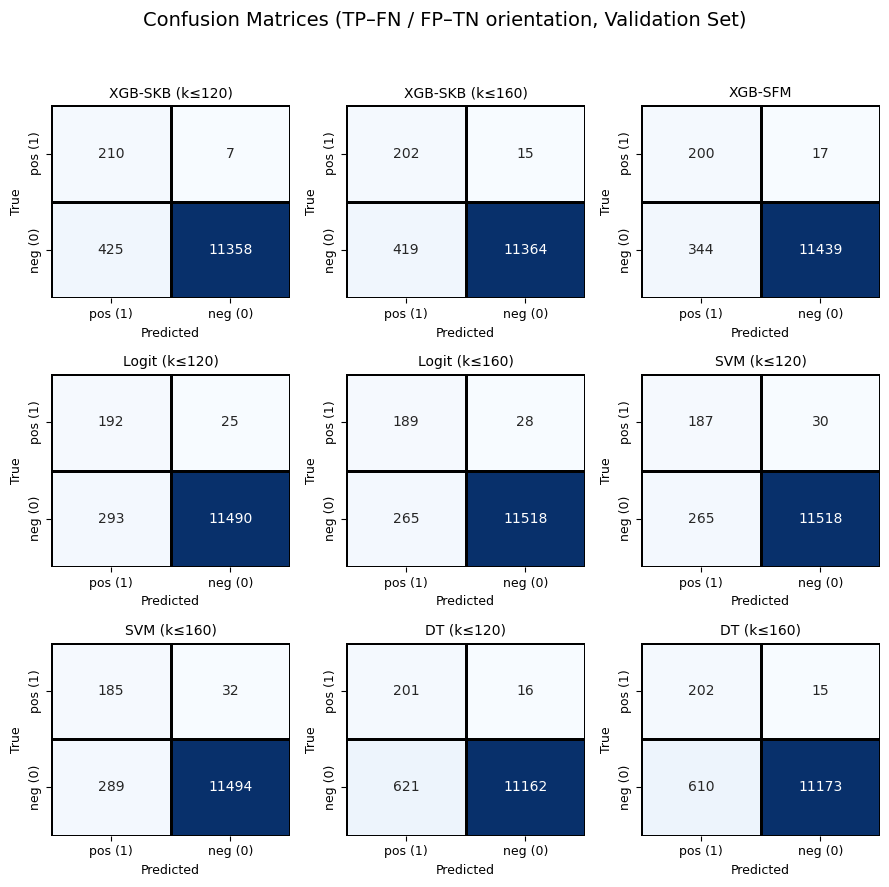

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_conf_matrices_grid_compact(y_true, model_preds, figsize=(10, 10)):
    """
    Compact 3x3 grid of confusion matrices with TP-first orientation.
    """
    assert len(model_preds) == 9, "Expected exactly 9 models."

    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.ravel()

    for ax, (name, y_pred) in zip(axes, model_preds):
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # TP-first

        sns.heatmap(
            cm,
            ax=ax,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            square=False,
            linewidths=0.8,
            linecolor="black",
            xticklabels=["pos (1)", "neg (0)"],
            yticklabels=["pos (1)", "neg (0)"],
            annot_kws={"size": 10},     # readable numbers
        )

        ax.set_title(name, fontsize=10, pad=6)
        ax.set_xlabel("Predicted", fontsize=9)
        ax.set_ylabel("True", fontsize=9)

        ax.tick_params(axis="both", labelsize=9)

    plt.suptitle(
        "Confusion Matrices (TP–FN / FP–TN orientation, Validation Set)",
        fontsize=14,
        y=0.98
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# ---- Fill this with your 9 predictions (already computed) ----
model_preds = [
    (r"XGB-SKB (k≤120)", pred_kb),
    (r"XGB-SKB (k≤160)", pred_kb_160),
    (r"XGB-SFM",         pred_sfm),
    (r"Logit (k≤120)",   pred_logit),
    (r"Logit (k≤160)",   pred_logit_160),
    (r"SVM (k≤120)",     pred_svm),
    (r"SVM (k≤160)",     pred_svm_160),
    (r"DT (k≤120)",      pred_dt),
    (r"DT (k≤160)",      pred_dt_160),
]

plot_conf_matrices_grid_compact(y_val, model_preds, figsize=(9, 9))


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_conf_matrices_2x5_with_legend(y_true, model_preds, figsize=(14, 6), save_path=None):
    """
    2x5 grid:
      - (0,0): annotation confusion matrix (TP/FN/FP/TN)
      - remaining 9 slots: confusion matrices for models
    """
    assert len(model_preds) == 9, "Expected exactly 9 models."

    fig, axes = plt.subplots(2, 5, figsize=figsize)
    axes = axes.ravel()

    # ---------- Annotation cell ----------
    legend_cm = np.array([[1, 1],
                          [1, 1]])

    sns.heatmap(
        legend_cm,
        ax=axes[0],
        annot=np.array([["TP", "FN"],
                        ["FP", "TN"]]),
        fmt="",
        cmap="Blues",
        cbar=False,
        square=False,
        linewidths=0.8,
        linecolor="black",
        xticklabels=["pos (1)", "neg (0)"],
        yticklabels=["pos (1)", "neg (0)"],
        annot_kws={"size": 12, "weight": "bold"},
    )

    axes[0].set_title("Confusion Matrix Layout", fontsize=14, pad=6)
    #axes[0].set_xlabel("Predicted", fontsize=9)
    axes[0].set_ylabel("Actual", fontsize=14)
    axes[0].tick_params(axis="both", labelsize=12)

# ---------- Actual model matrices ----------
    for idx, (ax, (name, y_pred)) in enumerate(zip(axes[1:], model_preds), start=1):
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # TP-first

        sns.heatmap(
            cm,
            ax=ax,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            square=False,
            linewidths=0.8,
            linecolor="black",
            xticklabels=["pos (1)", "neg (0)"],
            yticklabels=["pos (1)", "neg (0)"],
            annot_kws={"size": 12, "weight": "bold"},  # bold numbers
        )

        ax.set_title(name, fontsize=15, pad=6)

        # Determine subplot position
        row = idx // 5          # 0 or 1
        col = idx % 5           # 0..4

        # Only left-most column gets "Actual"
        if col == 0:
            ax.set_ylabel("Actual", fontsize=15)
        else:
            ax.set_ylabel("")

        # Only bottom row gets "Predicted"
        if row == 1:
            ax.set_xlabel("Predicted", fontsize=15)
        else:
            ax.set_xlabel("")

        ax.tick_params(axis="both", labelsize=13)


    plt.suptitle(
        "Confusion Matrices of All Nine Models",
        fontsize=22,
        y=.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path is not None:
        fig.savefig(save_path, dpi=600)

    plt.show()


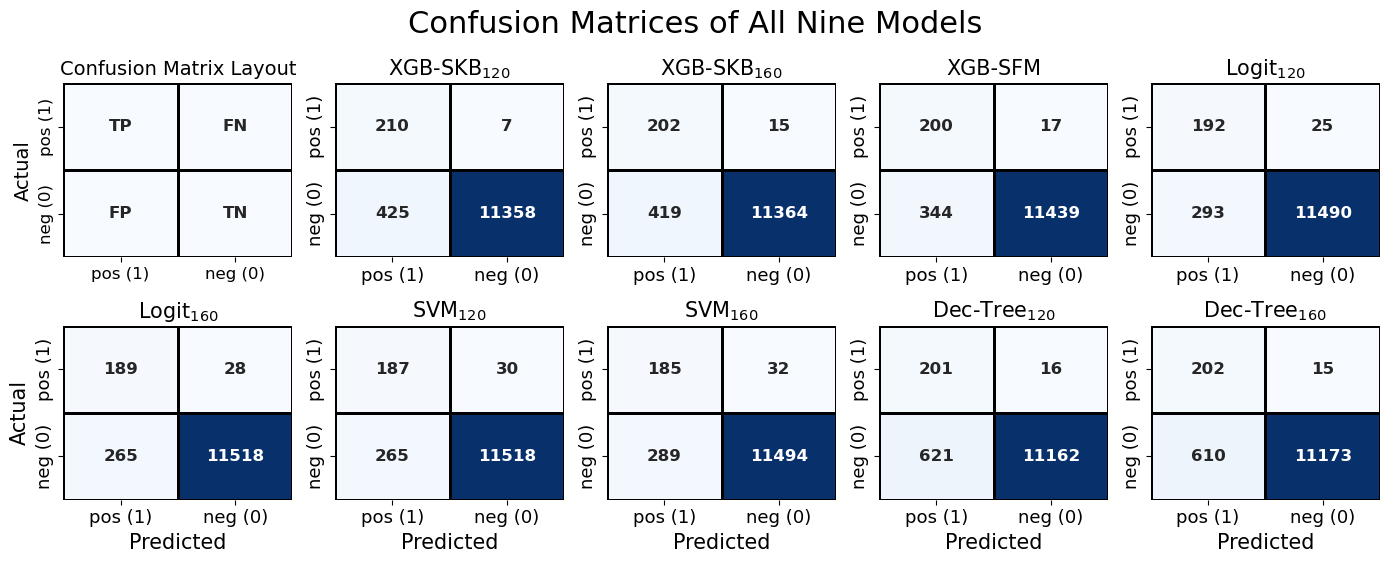

In [54]:
model_preds = [
    (r"XGB-SKB$_{120}$", pred_kb),
    (r"XGB-SKB$_{160}$", pred_kb_160),
    (r"XGB-SFM",         pred_sfm),
    (r"Logit$_{120}$",   pred_logit),
    (r"Logit$_{160}$",   pred_logit_160),
    (r"SVM$_{120}$",     pred_svm),
    (r"SVM$_{160}$",     pred_svm_160),
    (r"Dec-Tree$_{120}$",      pred_dt),
    (r"Dec-Tree$_{160}$",      pred_dt_160),
]

plot_conf_matrices_2x5_with_legend(y_val, model_preds, figsize=(14, 6), save_path='pics/conf_matrices.png')


## Feature Importance

Features seen by XGB: 120
Length of importances: 120


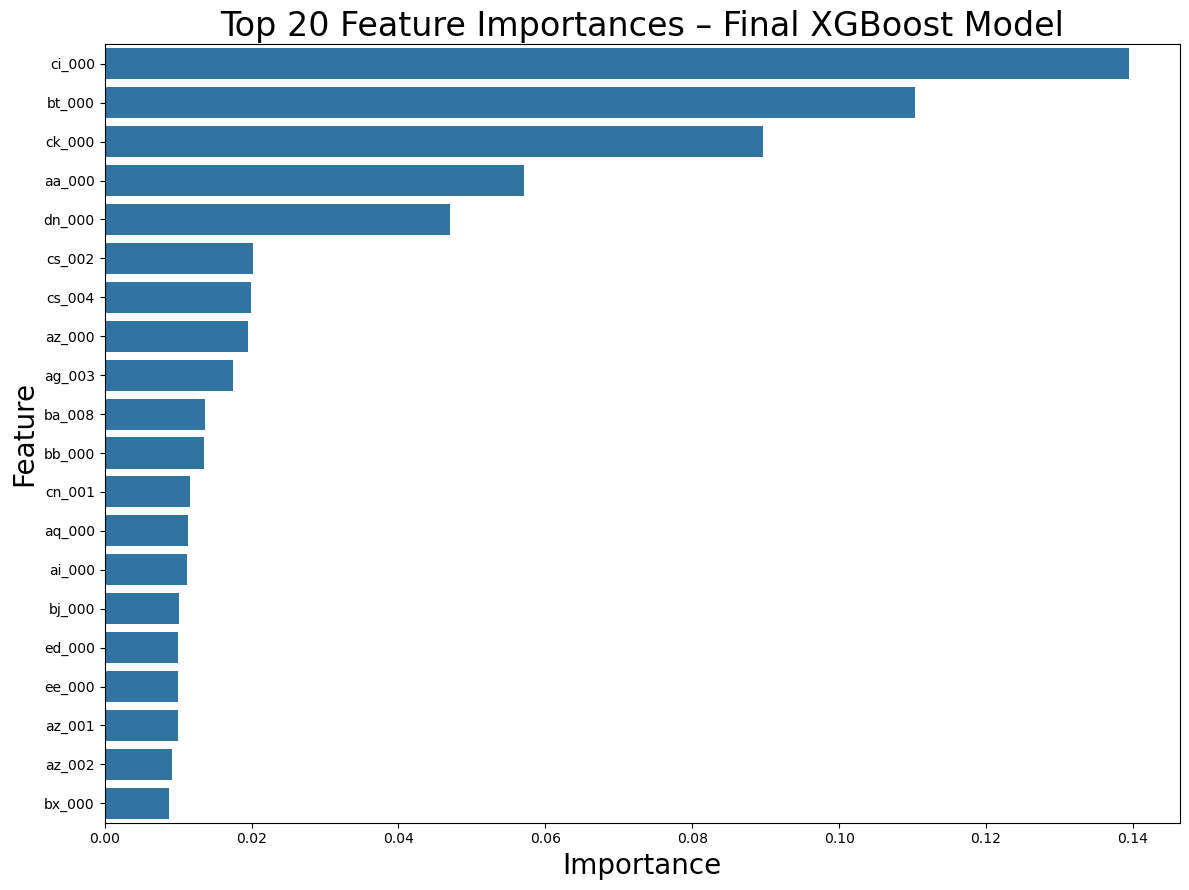

In [55]:
# Extract the final classifier and selector from the pipeline
final_xgb = final_model.named_steps["clf"]
selector  = final_model.named_steps["select"]

# Mask of features that were kept by SelectKBest
support_mask = selector.get_support()  # boolean mask of shape (n_features_before_selection,)

# Column names corresponding to selected features
selected_feature_names = X_train_final.columns[support_mask]

# Sanity check: lengths must match now
print("Features seen by XGB:", len(selected_feature_names))
print("Length of importances:", len(final_xgb.feature_importances_))

# Build importance DataFrame
imp_df = pd.DataFrame({
    "feature": selected_feature_names,
    "importance": final_xgb.feature_importances_
}).sort_values("importance", ascending=False)

# Plot top 20
fig_feat_importances = plt.figure(figsize=(12,9))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances – Final XGBoost Model", fontsize=24)
plt.xlabel("Importance", fontsize=20)
plt.ylabel("Feature", fontsize=20)
plt.tight_layout()
fig_feat_importances.savefig('pics/feature_importances.png', dpi=600)
plt.show()


### Comparing 10 Most Important Features for Best Model's Decision

In [32]:
top_n = 10
top_features = imp_df.head(top_n)["feature"].tolist()

import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_feature_distributions(X, y, features, bins=50):
    """
    X: DataFrame with features
    y: binary labels (0/1)
    features: list of feature names
    """
    n = len(features)
    ncols = 5
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
    axes = axes.flatten()

    for ax, feat in zip(axes, features):
        sns.histplot(
            X.loc[y == 0, feat],
            bins=bins,
            color="tab:blue",
            label="neg (0)",
            stat="density",
            alpha=0.5,
            ax=ax
        )
        sns.histplot(
            X.loc[y == 1, feat],
            bins=bins,
            color="tab:orange",
            label="pos (1)",
            stat="density",
            alpha=0.5,
            ax=ax
        )

        ax.set_title(feat, fontsize=12)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    # Remove empty subplots
    for ax in axes[len(features):]:
        ax.axis("off")

    plt.suptitle(
        "Distributions of Top-10 XGBoost Features (Validation Set)",
        fontsize=16,
        y=1.03
    )
    plt.tight_layout()
    plt.show()


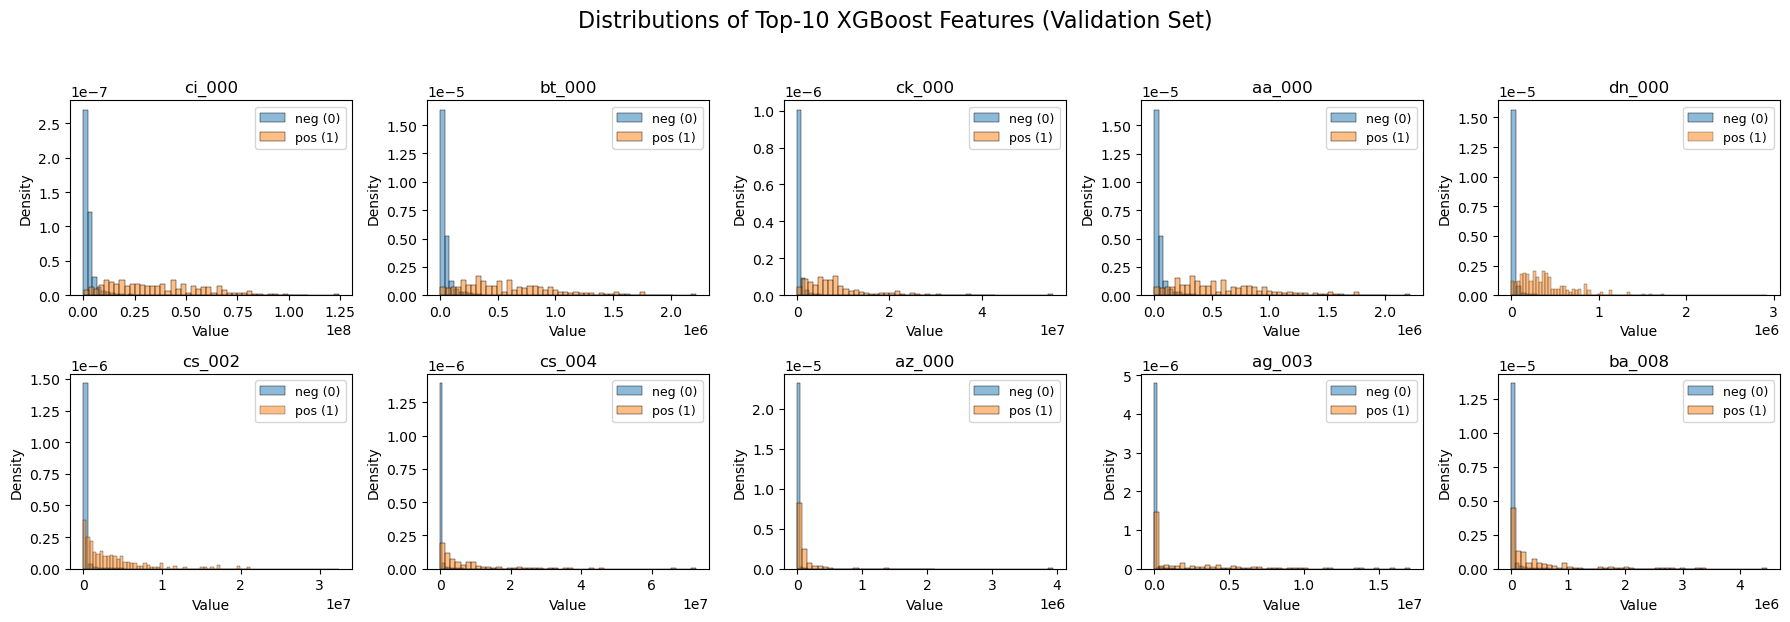

In [61]:
plot_top_feature_distributions(Xk_val, y_val, top_features)


In [33]:
def plot_top_feature_boxplots(X, y, features):
    fig, axes = plt.subplots(2, 5, figsize=(18, 6))
    axes = axes.flatten()

    for ax, feat in zip(axes, features):
        sns.boxplot(
            x=y,
            y=X[feat],
            ax=ax,
            palette=["tab:blue", "tab:orange"]
        )
        ax.set_title(feat, fontsize=12)
        ax.set_xlabel("Class (0=neg, 1=pos)")
        ax.set_ylabel("Value")

    for ax in axes[len(features):]:
        ax.axis("off")

    plt.suptitle(
        "Boxplots of Top-10 XGBoost Features by Class",
        fontsize=16,
        y=1.03
    )
    plt.tight_layout()
    plt.show()


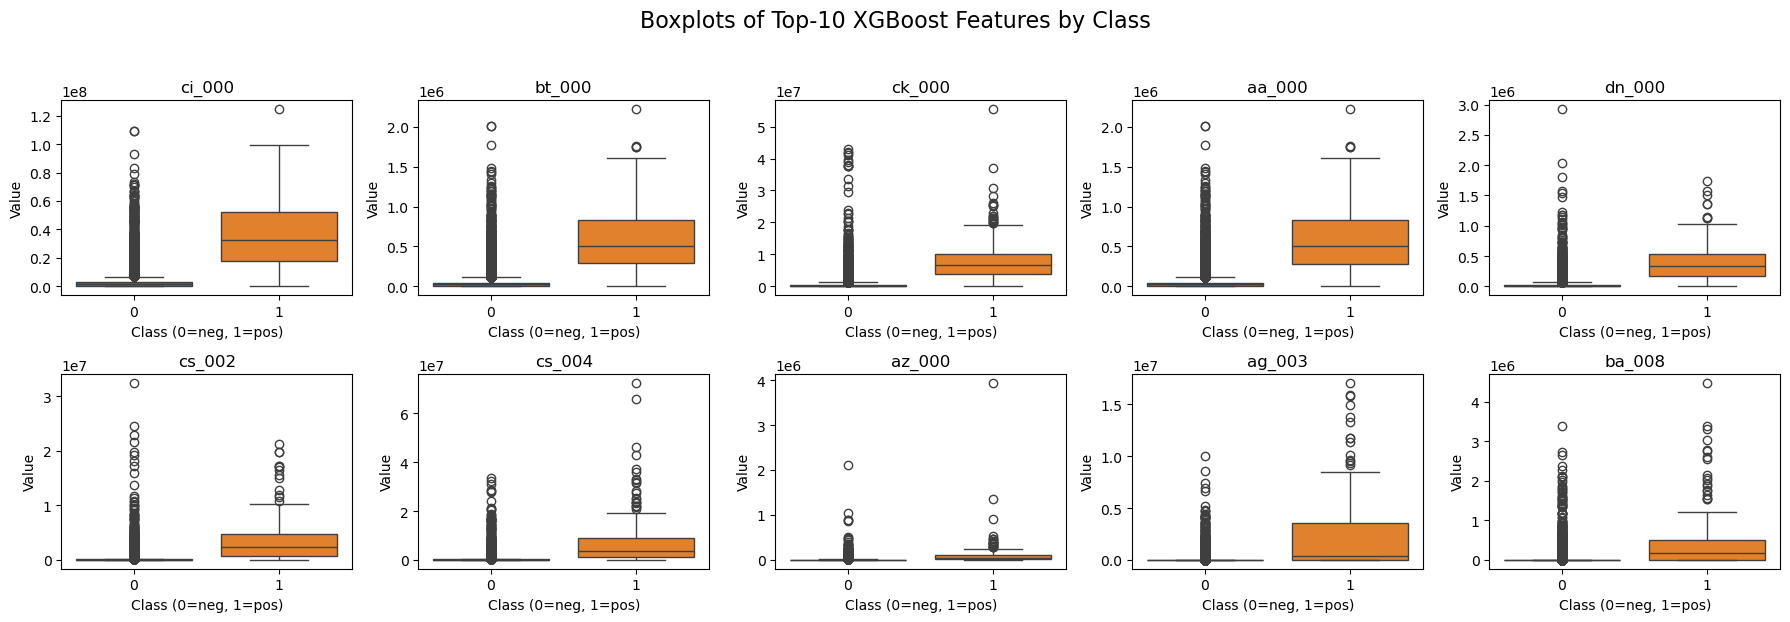

In [34]:
plot_top_feature_boxplots(Xk_val, y_val, top_features)


### Comparing 5 Most and 5 Least Important Features for Best Model's Decision

- Select Features

In [35]:
top_k = 5
bottom_k = 5

top_feats = imp_df.head(top_k)["feature"].tolist()
bottom_feats = imp_df.tail(bottom_k)["feature"].tolist()

feat_set = top_feats + bottom_feats
print("Top 5:", top_feats)
print("Bottom 5:", bottom_feats)


Top 5: ['ci_000', 'bt_000', 'ck_000', 'aa_000', 'dn_000']
Bottom 5: ['bz_000', 'az_007', 'ee_004', 'cs_005', 'at_000']


In [36]:
imp_df

,feature,importance
116,ci_000,0.139433
118,bt_000,0.110379
115,ck_000,0.089688
119,aa_000,0.057106
37,dn_000,0.047063
...,...,...
26,bz_000,0.000000
80,az_007,0.000000
68,ee_004,0.000000
94,cs_005,0.000000


#### Histogram Overlays

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_hist_overlays(X, y, features, bins=50, title=""):
    n = len(features)
    ncols = 5
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
    axes = axes.flatten()

    for ax, feat in zip(axes, features):
        sns.histplot(X.loc[y==0, feat], bins=bins, stat="density", alpha=0.5, ax=ax, label="neg (0)")
        sns.histplot(X.loc[y==1, feat], bins=bins, stat="density", alpha=0.5, ax=ax, label="pos (1)")
        ax.set_title(feat, fontsize=12)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    for ax in axes[len(features):]:
        ax.axis("off")

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


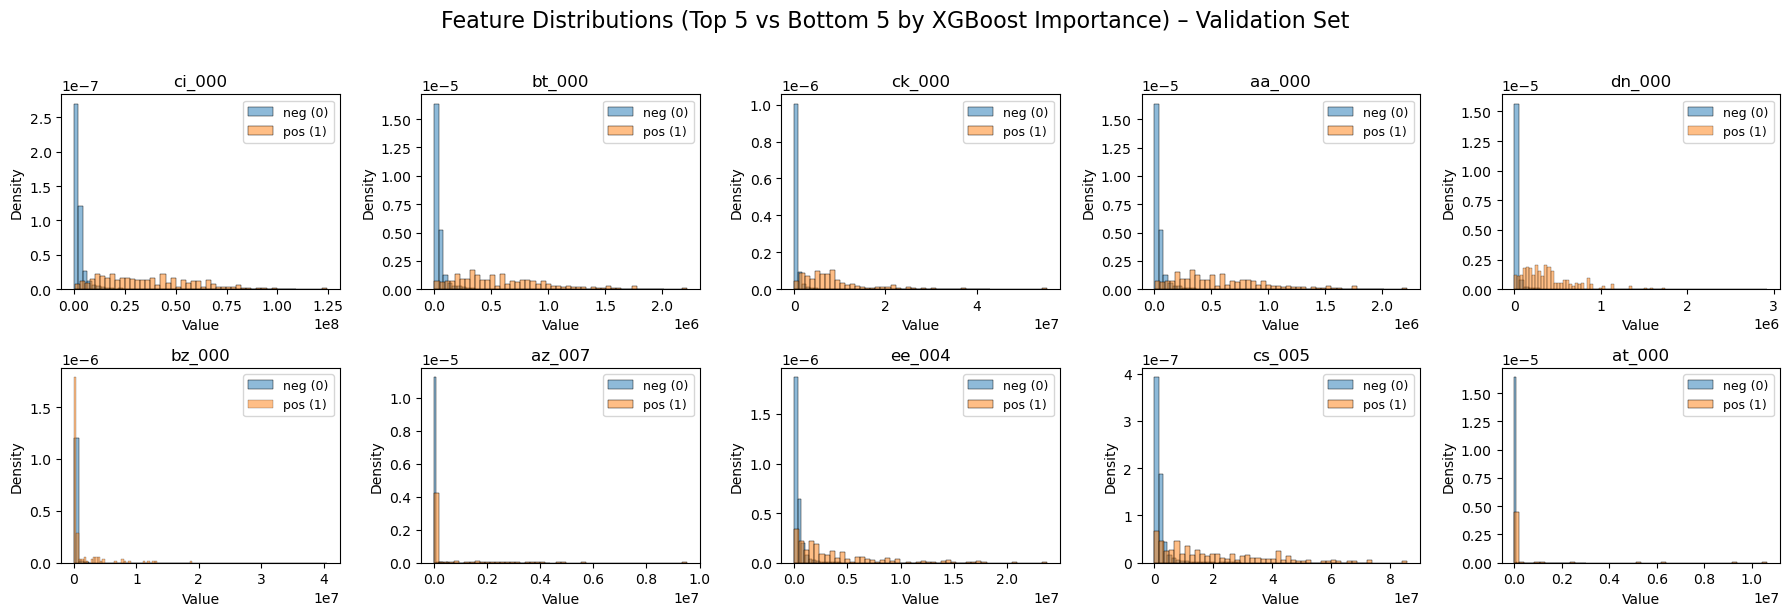

In [38]:
plot_feature_hist_overlays(
    Xk_val, y_val, feat_set,
    bins=50,
    title="Feature Distributions (Top 5 vs Bottom 5 by XGBoost Importance) – Validation Set"
)

#### Boxplots

In [39]:
def plot_feature_boxplots(X, y, features, title=""):
    fig, axes = plt.subplots(2, 5, figsize=(18, 6))
    axes = axes.flatten()

    for ax, feat in zip(axes, features):
        sns.boxplot(x=y, y=X[feat], ax=ax)
        ax.set_title(feat, fontsize=12)
        ax.set_xlabel("Class (0=neg, 1=pos)")
        ax.set_ylabel("Value")

    for ax in axes[len(features):]:
        ax.axis("off")

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


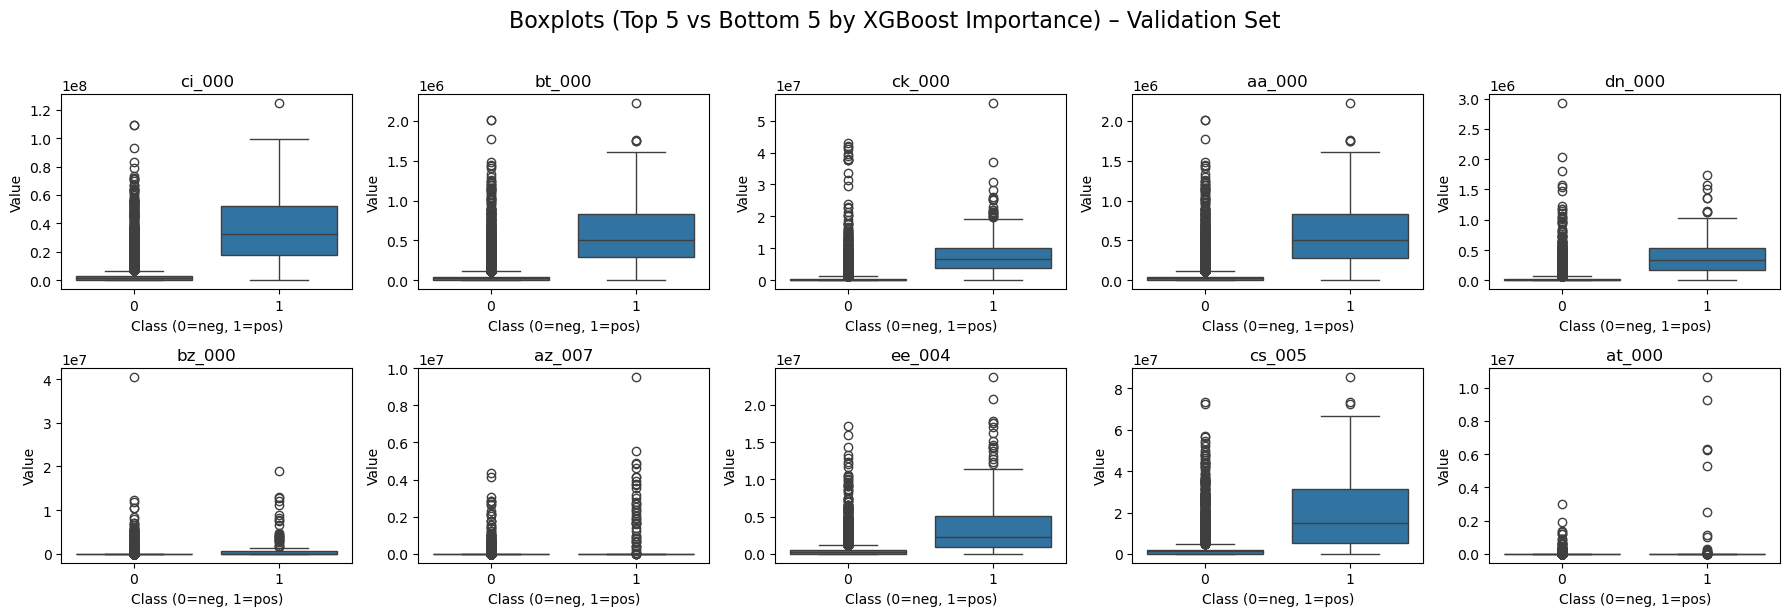

In [40]:
plot_feature_boxplots(
    Xk_val, y_val, feat_set,
    title="Boxplots (Top 5 vs Bottom 5 by XGBoost Importance) – Validation Set"
)


#### Feature Importance vs. Missingness

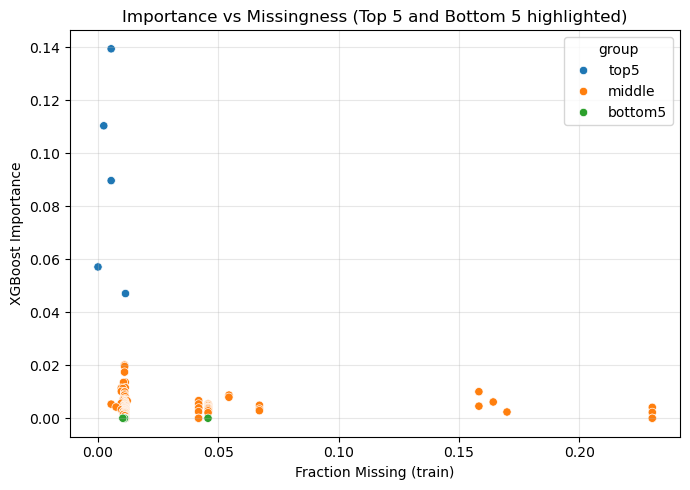

In [41]:
missing_frac = X_train_final.isna().mean()
imp_tmp = imp_df.copy()
imp_tmp["missing_fraction"] = imp_tmp["feature"].map(missing_frac)
imp_tmp["group"] = "middle"
imp_tmp.loc[imp_tmp["feature"].isin(top_feats), "group"] = "top5"
imp_tmp.loc[imp_tmp["feature"].isin(bottom_feats), "group"] = "bottom5"

plt.figure(figsize=(7,5))
sns.scatterplot(data=imp_tmp, x="missing_fraction", y="importance", hue="group")
plt.xlabel("Fraction Missing (train)")
plt.ylabel("XGBoost Importance")
plt.title("Importance vs Missingness (Top 5 and Bottom 5 highlighted)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

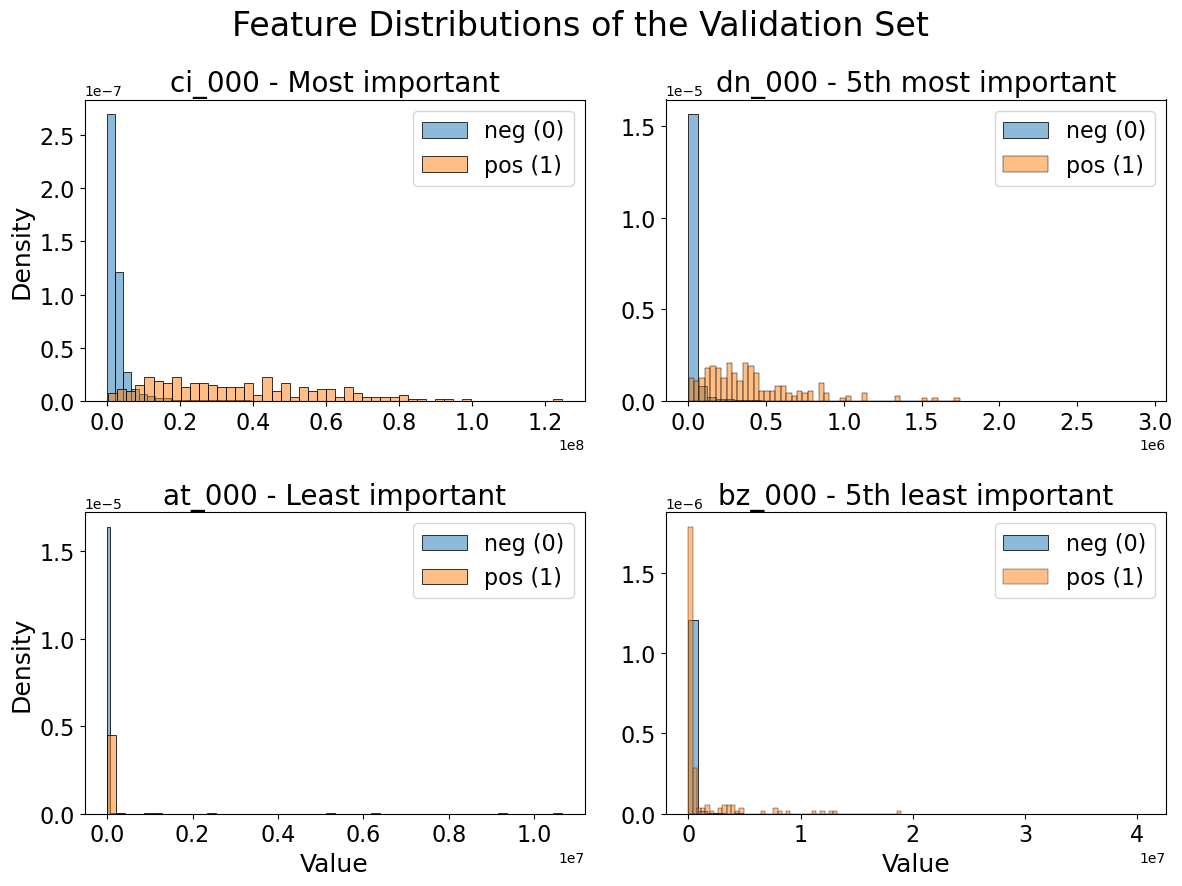

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_hist_overlays_2x2(
    X, y, imp_df,
    bins=50,
    alpha=0.5,
    fig_size=(12, 8),
    title_fs=16,
    subtitle_fs=12,
    axis_label_fs=14,
    tick_fs=12,
    legend_fs=11,
    legend_loc="upper right",
    save_path=None
):
    """
    2x2 overlay histograms (neg vs pos) for:
      - Most important feature (rank 1)      -> top-left
      - 5th most important feature (rank 5) -> top-right
      - Least important feature (rank -1)   -> bottom-left
      - 5th least important feature (rank -5)-> bottom-right

    X: pandas DataFrame (validation features)
    y: array-like or pandas Series (0/1 labels), aligned with X
    imp_df: DataFrame with columns ["feature","importance"] sorted DESC by importance
    """

    # --- pick the 4 features (with safety for shorter lists) ---
    imp_df_sorted = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

    if len(imp_df_sorted) < 5:
        raise ValueError(f"Need at least 5 features in imp_df, got {len(imp_df_sorted)}.")

    f_most  = imp_df_sorted.loc[0, "feature"]
    f_5most = imp_df_sorted.loc[4, "feature"]
    f_least = imp_df_sorted.loc[len(imp_df_sorted)-1, "feature"]
    f_5least = imp_df_sorted.loc[len(imp_df_sorted)-5, "feature"]

    # Layout order you requested:
    feats = [
        f"{f_most} - Most important",
        f"{f_5most} - 5th most important",
        f"{f_least} - Least important",
        f"{f_5least} - 5th least important",
    ]

    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.ravel()

    # Super-title explicitly states what each panel is
    suptitle = ("Feature Distributions of the Validation Set")
    fig.suptitle(suptitle, fontsize=title_fs)

    for idx, (ax, feat) in enumerate(zip(axes, feats)):
        # overlay histograms for the two classes
        sns.histplot(
            X.loc[np.asarray(y) == 0, feat.split(' - ')[0]],
            bins=bins, stat="density", alpha=alpha, ax=ax, label="neg (0)"
        )
        sns.histplot(
            X.loc[np.asarray(y) == 1, feat.split(' - ')[0]],
            bins=bins, stat="density", alpha=alpha, ax=ax, label="pos (1)"
        )

        # subplot title = feature name + annotation
        ax.set_title(feat, fontsize=subtitle_fs)

        # Axis labels:
        row = idx // 2  # 0 top row, 1 bottom row
        col = idx % 2   # 0 left col, 1 right col

        if col == 0:
            ax.set_ylabel("Density", fontsize=axis_label_fs)
        else:
            ax.set_ylabel("")

        if row == 1:
            ax.set_xlabel("Value", fontsize=axis_label_fs)
        else:
            ax.set_xlabel("")

        ax.tick_params(axis="both", labelsize=tick_fs)
        ax.legend(fontsize=legend_fs, loc=legend_loc)

    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=600)

    plt.show()

plot_feature_hist_overlays_2x2(
    X=Xk_val,
    y=y_val,
    imp_df=imp_df,
    bins=50,
    alpha=0.5,
    fig_size=(12, 9),
    title_fs=24,
    subtitle_fs=20,
    axis_label_fs=18,
    tick_fs=16,
    legend_fs=16,
    legend_loc="upper right",
    save_path="pics/feature_hist_overlays_2x2.png"
)
